In [79]:
from typing import Optional

import os
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
import torch
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader

CAUSAL_COEFF_STRENGTH = 1.7
NETWORKS_DIR_PATH = "/Users/wciezobka/sano/projects/masters-thesis/Datasets/NeuroFlicks/networks"

In [81]:
class ConnectivityDataset(Dataset):

    @staticmethod
    def nx2geometric(nx_graph: nx.DiGraph) -> Data:
        """
        Converts a networkx graph to a PyTorch Geometric Data object.
        """

        return Data(
            x=torch.ones(len(nx_graph.nodes), 1),
            edge_index=torch.tensor(list(nx_graph.edges)).t().contiguous(),
            edge_attr=torch.tensor(list(nx.get_edge_attributes(nx_graph, 'weight').values()), dtype=torch.float),
        )

    def __init__(
            self,
            networks_dir: str,
            causal_coeff_strength: Optional[float] = None,
            causal_coeff_threshold: Optional[float] = None,
        ):

        assert causal_coeff_strength is not None or causal_coeff_threshold is not None, \
            "Either causal_coeff_strength or causal_coeff_threshold must be set"

        self.networks_dir = networks_dir
        self.causal_coeff_strength = causal_coeff_strength
        self.causal_coeff_threshold = causal_coeff_threshold
       
       # List of all networks
        np_files = os.listdir(self.networks_dir)

        # Get labels from file names
        self.labels = np.array([np_file[4:7] == 'PAT' for np_file in np_files])

        # Load all networks to numpy networks
        np_networks = [np.load(os.path.join(networks_dir, np_file))[1] for np_file in np_files]

        # Preprocess networks
        if causal_coeff_strength is not None:
            score_mean, score_std = np.array(np_networks).mean(), np.array(np_networks).std()
            np_networks = np_networks > score_mean + self.causal_coeff_strength * score_std
        else:
            np_networks = np.where(np.array(np_networks) < self.causal_coeff_threshold, 0, np_networks)
        
        # Convert to networkx graphs
        self.nx_dataset = [nx.from_numpy_array(np_network, create_using=nx.DiGraph) for np_network in np_networks]

        # Balance of control and patological samples
        self.n_control = len(self.labels) - self.labels.sum()
        self.n_patological = self.labels.sum()
    
    def subjects_info(self):
        return {"Control": self.n_control, "Patological": self.n_patological}
    
    def len(self):
        return len(self.nx_dataset)
    
    def get(self, idx):
        return self.nx2geometric(self.nx_dataset[idx])
    
    def __getitem__(self, idx) -> Data:
        return self.get(idx)
    
    def __len__(self) -> int:
        return self.len()

In [82]:
dataset_geometric = ConnectivityDataset(NETWORKS_DIR_PATH, causal_coeff_threshold=0.5)

In [84]:
dataset_geometric.subjects_info()

{'Control': 69, 'Patological': 382}

In [77]:
sample_graph_id = 0
sample_graph = dataset_geometric[sample_graph_id]

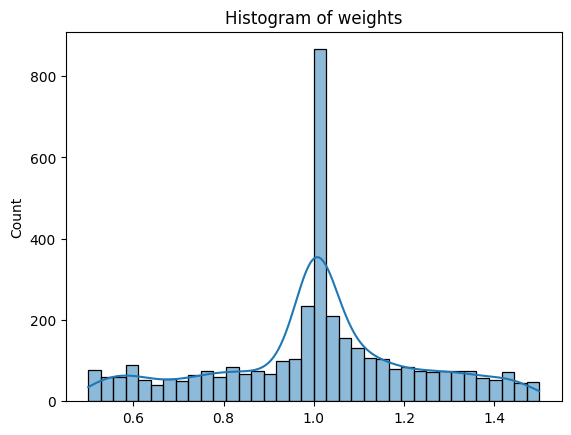

In [78]:
# Plot histogram of weights with sns
sns.histplot(sample_graph.edge_attr.numpy(), kde=True)
plt.title("Histogram of weights")
plt.show()

In [90]:
dataloader = DataLoader(dataset_geometric, batch_size=32, shuffle=True)

In [92]:
for batch in dataloader:
    print(batch)
    break

DataBatch(x=[3200, 1], edge_index=[2, 141049], edge_attr=[141049], batch=[3200], ptr=[33])
